In [ ]:
# %pip install torch torchvision torchaudio pytorch-optimizer matplotlib -- uncomment and run this in a dedicated cell, doing this resolved the slight issues faced when attempting to use pytorch optimizer after running in the terminal.



# to activate the venv environtment:

# python -m venv venv
# .\venv\Scripts\activate

# Installing the following libraries:


    # pip install torch torchvision torchaudio pytorch-optimizer matplotlib -- using the top command in a dedicated cell is best

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import pytorch_optimizer as optim
import matplotlib.pyplot as plt

# To start off the notebook code for the deep learning training of the ML model, The following is what we used for setting up the environment.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# data transformations, we are converting the image to the PyTorch tensor and normalizing it
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# the dataset we decided to use is the Fashion-MNIST
full_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

# Tweak: Implement an 80/20 Validation Split
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Create DataLoaders to feed data into the model in batches
batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

# Step 2: Model Definition (Applying Professor's Tweaks)
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        

        # as shown in previous lectures, we decided to adopt the multilayered CNN model structure:


        # 1st Layer - This is the first convolutional layer. We are taking in our single-channel (grayscale) image and outputting 32 feature maps.
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        # 2nd Layer - Used a pooling layer to downsample the image dimensions, and to save on the computation as well 
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # 3rd Layer - This is the second convolutional layer. It is taking those 32 feature maps and expanding them to 64 feature maps
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        # 4th Layer - The following is for adding a Dropout layer, with a 20% probability. Based on previous modules and labs covering the issues of overfitting, the purpose of this is to prevent the model from overfitting
        self.dropout = nn.Dropout(p=0.2)
        
        # 5th Layer: Fully connected layer: after pooling, our 28x28 images shrink to 14x14. We flatten that and connect it to 64 nodes.
        self.fc1 = nn.Linear(64 * 14 * 14, 64)
        # Final output layer: mapping everything down to 10 units to match our 10 clothing classes in Fashion-MNIST.
        self.fc2 = nn.Linear(64, 10)
        
        # Using ReLU, we applied the He Initialization to the layers in the following commands below:
        nn.init.kaiming_normal_(self.conv1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv2.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')

    def forward(self, x):
        # This is for the forward pass: 
            # Conv1 --> ReLU --> Pool
        x = self.pool(torch.relu(self.conv1(x)))
        # Forward pass: Conv2 --> ReLU
        x = torch.relu(self.conv2(x))
        # Layer 4: Flatten
        x = x.view(x.size(0), -1)
        # Dropout --> FC1 --> ReLU
        x = torch.relu(self.fc1(self.dropout(x)))


        
        # Output FC2
        x = self.fc2(x)
        return x

Using device: cpu


In [2]:
# Step 3: The Training Loop
def train_and_validate(model, optimizer, criterion, epochs=5):
    train_losses = []
    val_accuracies = []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()         # Clear old gradients
            outputs = model(images)       # Forward pass
            loss = criterion(outputs, labels) # Calculate error
            loss.backward()               # Backward pass
            optimizer.step()              # Update weights
            
            running_loss += loss.item()
            
        # in the following section, the purpose is for verification
        model.eval() # Turn off dropout for testing
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
        # Record metrics
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        val_accuracies.append(epoch_acc)
        
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Val Accuracy: {epoch_acc:.2f}%')
        
    return train_losses, val_accuracies


Training with LAMB: 
Epoch [1/5], Loss: 0.5839, Val Accuracy: 86.69%
Epoch [2/5], Loss: 0.3504, Val Accuracy: 89.33%
Epoch [3/5], Loss: 0.2959, Val Accuracy: 90.16%
Epoch [4/5], Loss: 0.2614, Val Accuracy: 90.18%
Epoch [5/5], Loss: 0.2337, Val Accuracy: 90.46%

Training with Lion: 
Epoch [1/5], Loss: 0.4116, Val Accuracy: 89.89%
Epoch [2/5], Loss: 0.2383, Val Accuracy: 90.78%
Epoch [3/5], Loss: 0.1909, Val Accuracy: 91.37%
Epoch [4/5], Loss: 0.1565, Val Accuracy: 91.63%
Epoch [5/5], Loss: 0.1311, Val Accuracy: 91.83%

Training with AdEMAMix: 
Epoch [1/5], Loss: 0.4113, Val Accuracy: 89.07%
Epoch [2/5], Loss: 0.2520, Val Accuracy: 90.81%
Epoch [3/5], Loss: 0.1974, Val Accuracy: 90.62%
Epoch [4/5], Loss: 0.1635, Val Accuracy: 91.25%
Epoch [5/5], Loss: 0.1348, Val Accuracy: 92.12%


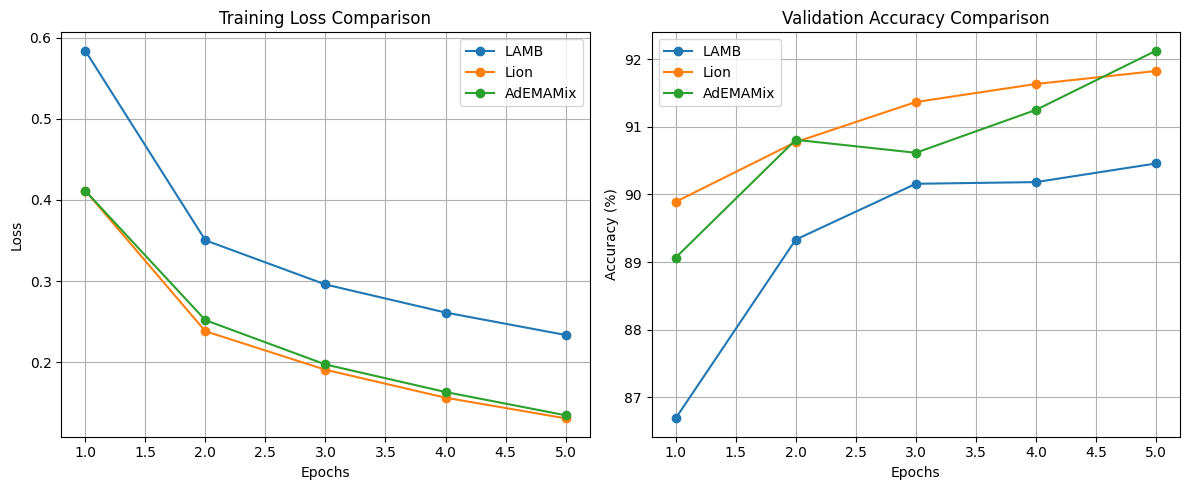

In [4]:
# Step 4: Optimizer Execution
criterion = nn.CrossEntropyLoss()
num_epochs = 5
results = {}


# 1. Train with LAMB
print("\nTraining with LAMB: ")
model_lamb = FashionCNN().to(device)
optimizer_lamb = optim.Lamb(model_lamb.parameters(), lr=0.001)
loss_lamb, acc_lamb = train_and_validate(model_lamb, optimizer_lamb, criterion, num_epochs)
results['LAMB'] = {'loss': loss_lamb, 'acc': acc_lamb}

# 2. Train with Lion
print("\nTraining with Lion: ")
model_lion = FashionCNN().to(device)
# Note: Lion generally requires a much smaller learning rate
optimizer_lion = optim.Lion(model_lion.parameters(), lr=1e-4, weight_decay=0.01)
loss_lion, acc_lion = train_and_validate(model_lion, optimizer_lion, criterion, num_epochs)
results['Lion'] = {'loss': loss_lion, 'acc': acc_lion}

# 3. Train with AdEMAMix
print("\nTraining with AdEMAMix: ")
model_ademamix = FashionCNN().to(device)
optimizer_ademamix = optim.AdEMAMix(model_ademamix.parameters(), lr=0.001)
loss_ademamix, acc_ademamix = train_and_validate(model_ademamix, optimizer_ademamix, criterion, num_epochs)
results['AdEMAMix'] = {'loss': loss_ademamix, 'acc': acc_ademamix}

# Step 5: Visualization & Comparison
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot 1: Training Loss
plt.subplot(1, 2, 1)
for opt_name, data in results.items():
    plt.plot(epochs_range, data['loss'], label=opt_name, marker='o')
plt.title('Training Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Validation Accuracy
plt.subplot(1, 2, 2)
for opt_name, data in results.items():
    plt.plot(epochs_range, data['acc'], label=opt_name, marker='o')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()